# Pipeline para el entrenamiento de Redes Neuronales

El objetivo de este post es exponer un proceso especifico cuando se requiera aplicar una red neuronal para abordar un nuevo problema. Se basa en construir la red de simple a complejo, y en cada paso del camino hacer hipótesis concretas de lo que se espera que ocurra y posteriormente validarlas con un conjunto de experimentación que nos permita la detección pronta de posibles problemas en la arquitectura. Con todo ello, lo que se intenta evitar es introducir una complejidad excesiva a nuestro problema que seguramente introducirá errores o configuraciones erróneas muy difíciles o casi imposibles de detectar, ya que su red mal configurada, la mayoría de las veces entrenará sin arrojar excepciones, aunque en silencio funcionará un poco peor.

## Análisis y limpieza de los Datos

El primer paso antes de empezar a crear o desarrollar la arquitectura de la red neuronal es comenzar inspeccionando a fondo sus datos. Este paso es muy crítico y por ello se debe dedicar una gran parte del tiempo total al escaneando de miles de ejemplos, entendiendo su distribución y buscando patrones. Algunas consideraciones a tener en cuenta en el análisis exploratorio y limpieza de datos serían:

- Datos duplicados, en el caso de datos estructurados pueden ser lineas del dataframe repetidas o en el caso de imágenes podrían ser copias duplicadas con o sin el mismo nombre.
- Etiquetas corruptas, datos faltantes o datos inconsistentes.
- Valores atípicos en cualquiera de las variables independientes.
- Búsqueda de los desequilibrios de datos y posibles sesgos en las variables independientes.
- Estudio que toman la variación de las variables dependientes.
- Reducción en la resolución de las imágenes siempre que la calidad del detalle sea la apropiada.
- Posible ruido en las etiquetas o incluso en alguna variable dependiente.
- Transformaciones de los datos para adaptar la varianza de los datos a una distribución normal.
- Categorización de las variables categóricas.

In [1]:
!pip install tf-nightly

In [2]:
!pip install -q efficientnet

In [3]:
# Importar las librerias y otros ficheros de python
import os
import math
import numpy as np
import random as rn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import efficientnet.tfkeras as efn

# Configurar las semillas para reproducibilidad
os.environ['PYTHONHASHSEED'] = '0'
seed = 99
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)

In [4]:
import matplotlib.style as style 
style.use('ggplot')

In [5]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%load_ext tensorboard

> Descarga del dataset de ejemplo:

In [6]:
data_directory = "dataset/"
folder_data = "PetImages/"
directory = os.path.join(data_directory, folder_data)

if not os.path.isdir(data_directory):
  os.mkdir(data_directory)
  !curl -o dataset/kagglecatsanddogs.zip https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
  !unzip -q dataset/kagglecatsanddogs.zip -d dataset/

  # Forzar desbalanceo del dataset
  items_cats = [item for item in os.listdir(os.path.join(directory, "Cat")) if 
                                  os.path.isfile(os.path.join(directory, "Cat", item))]
  _ = [os.remove(os.path.join(directory, "Cat", item)) for item in rn.choices(items_cats, k=int(len(items_cats)*0.5)) if 
                                  os.path.isfile(os.path.join(directory, "Cat", item))]

!ls dataset/PetImages/


Cat  Dog


> Filtrado de imagenes corruptas

In [7]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(directory, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [8]:
items_cats = [item for item in os.listdir(os.path.join(directory, "Cat")) if 
                                 os.path.isfile(os.path.join(directory, "Cat", item))]
items_dogs = [item for item in os.listdir(os.path.join(directory, "Dog")) if 
                                 os.path.isfile(os.path.join(directory, "Dog", item))]

print(f'Numero de imagenes correspondientes a gatos: {len(items_cats)}')
print(f'Numero de imagenes correspondientes a perros: {len(items_dogs)}')
print(f'Relación de desbalanceo gatos/perros: {len(items_cats)/len(items_dogs)}')

Numero de imagenes correspondientes a gatos: 7163
Numero de imagenes correspondientes a perros: 11670
Relación de desbalanceo gatos/perros: 0.613796058269066


> Generación del Dataset 

In [9]:
image_size = (204, 204)
batch_size = 32
num_classes = 2

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)

Found 18831 files belonging to 2 classes.
Using 15065 files for training.
Found 18831 files belonging to 2 classes.
Using 3766 files for validation.


> Visualización de los datos

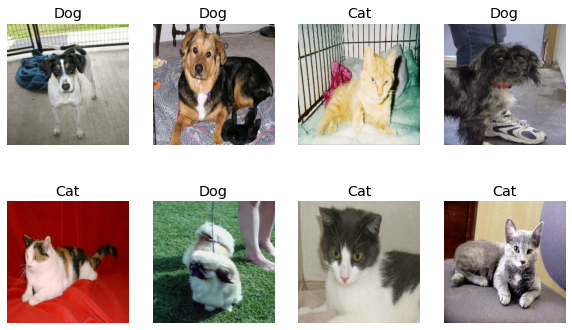

In [10]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Cat" if int(labels[i]) == 0 else "Dog")
        plt.axis("off")

## Configuración de la arquitectura end-to-end.

Una vez entendidos los datos, el siguiente paso es configurar la función de entrenamiento y evaluación, que nos permita ejecutarla y ganar confianza en su inferencia a través de una serie de experimentos. en esta etapa, es muy recomendable elegir un modelo simple, el cual no ha sido modificado de ninguna manera, por ejemplo, un clasificador lineal o un red convolucional simple. Con ello, el objetivo será entrenarlo, visualizar las pérdidas y las métricas para cada epoch, predecir resultados en base a la inferencia del modelo y realizar una serie de experimentos de ablación con hipótesis explícitas en cada experimento realizado.


In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
     # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(32, 3, strides=3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    initializer_weights = tf.keras.initializers.GlorotUniform()
    initializer_bias = tf.constant_initializer(0.6)
    outputs = layers.Dense(units, bias_initializer = initializer_bias, 
                           kernel_initializer = initializer_weights,
                           activation = activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 75, 75, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)       

In [12]:
EPOCHS = 5 #Parámetro general en el Pipeline de entrenamiento

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
    validation_steps = len(val_ds)
)

Epoch 1/5
471/471 [==============================] - 49s 104ms/step - loss: 0.6647 - accuracy: 0.6117 - val_loss: 0.6313 - val_accuracy: 0.6283
Epoch 2/5
471/471 [==============================] - 48s 101ms/step - loss: 0.6322 - accuracy: 0.6346 - val_loss: 0.6266 - val_accuracy: 0.6306
Epoch 3/5
471/471 [==============================] - 47s 100ms/step - loss: 0.6268 - accuracy: 0.6340 - val_loss: 0.6237 - val_accuracy: 0.6349
Epoch 4/5
471/471 [==============================] - 48s 101ms/step - loss: 0.6248 - accuracy: 0.6405 - val_loss: 0.6375 - val_accuracy: 0.6389
Epoch 5/5
471/471 [==============================] - 48s 101ms/step - loss: 0.6273 - accuracy: 0.6353 - val_loss: 0.6211 - val_accuracy: 0.6391


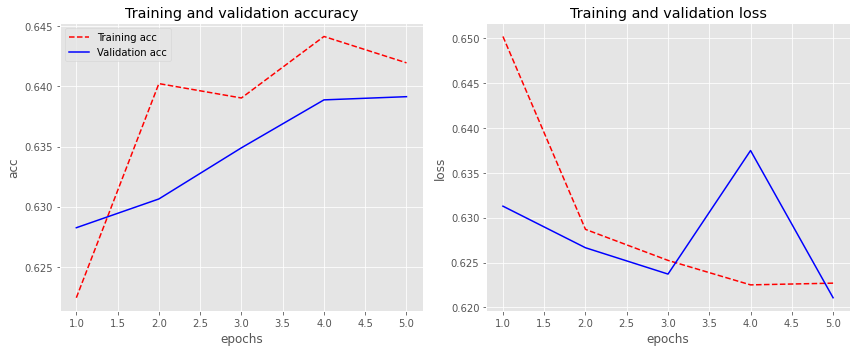

In [13]:
def plot_history(history):
  """
    Generación del gráfico de Visualización de métricas
    y perdidas para cada epochs del entrenamiento-validación.
  """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1, 1)
  fig, axs = plt.subplots(1, 2,figsize=(12, 5))

  axs[0].plot(epochs, acc, 'r--', label='Training acc')
  axs[0].plot(epochs, val_acc,  'b', label='Validation acc')
  axs[0].set_title('Training and validation accuracy')
  axs[0].set_ylabel('acc')
  axs[0].set_xlabel('epochs')
  axs[0].legend()

  axs[1].plot(epochs, loss, 'r--' )
  axs[1].plot(epochs, val_loss , 'b' )
  axs[1].set_title ('Training and validation loss')
  axs[1].set_ylabel('loss')
  axs[1].set_xlabel('epochs')

  fig.tight_layout()
  plt.show()

plot_history(history)

Algunas sugerencias en este paso son:

- **Semilla aleatoria fija:** esto garantiza la repetibilidad de sus experimentos, eliminando el factor de variación y permitiendo que pueda comparar los distintos experimentos.
```python
# Configurar las semillas para reproducibilidad
os.environ['PYTHONHASHSEED'] = '0'
seed = 99
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
```



- **Simplificar:** En esta etapa es muy importante simplificar el pipeline de entrenamiento, es decir, deshabilitar cualquier método de regulación añadido como por ejemplo podría ser el aumento de datos, que pueda inducir algún tipo de error en la red.


- **Visualización del tensor de entrada de la red:** Muy importante preparar en su código la visualización del tensor de entrada a la red. Con ello se asegura la consistencia de los datos de entrada y ayuda a la detección temprana de fallos en el aumento de datos o en la codificación de estos.

In [14]:
train_ds.as_numpy_iterator().next()[0].shape

(32, 224, 224, 3)

- **Agregar datos significativos en la evaluación:** Evaluar la pérdida de evaluación en todo el conjunto de test.
```python
history = model.fit(
    train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds,
    validation_steps = total_imag_val // batch_size # con generador: validation_steps = len(val_ds) 
)
```

- **Visualización de la dinámica de predicción:** Se pretende visualizar las predicciones del modelo en un lote de prueba fijo durante la inferencia. Esta dinámica de cómo varían las predicciones permiten intuir de buena manera el progreso de entrenamiento.Si se observa gran variabilidad y fluctuaciones demasiado agresivas, esto es síntoma de inestabilidades en el proceso de entrenamiento.

- **Verificar la pérdida en la inicialización:** Verificar que su pérdida comience en un valor de inicialización correcto. 
El objetivo de la inicialización de peso es evitar que las salidas de activación de la capa exploten o desaparezcan durante el proceso de *forward pass* de la red neuronal profunda. Si ocurre cualquiera de los dos, los gradientes de pérdida serán demasiado grandes o demasiado pequeños para fluir hacia atrás de manera beneficiosa, y la red tardará más en converger, si es que es capaz de hacerlo.
Para conseguir una convengencia sustancialmente más rápida y una mayor precisión en los resultados, la mejor forma es inicializar los pesos con un inicializador de pesos *GlorotNormal* o *GlorotUniform*.
```python
initializer_weights = tf.keras.initializers.GlorotUniform()
outputs = layers.Dense(units, kernel_initializer = initializer_weights, activation = activation)(x)
```


- **Inicialización de los pesos:** Inicialización de los pesos de las capas finales de manera correcta. Por ejemplo, si se tiene un conjunto de datos desequilibrado a relación 1:5, se debe asignar el sesgo en los logits de modo que la red sea capaz de predecir la probabilidad de 0.25 en la inicialización. Esta inicialización ayudará a la red a converger de manera más rápida y eliminará las primeras iteraciones del entrenamiento, donde la red esta aprendiendo el sesgo del conjunto de datos.


In [15]:
print(f'Relación de desbalanceo gatos/perros: {len(items_cats)/len(items_dogs)}')

Relación de desbalanceo gatos/perros: 0.613796058269066


> Ene ste caso la relación de desequilibrio entre las dos categorias es de un *0.6* aproximadamente, por ello:
```python
initializer_weights = tf.keras.initializers.GlorotUniform()
initializer_bias = tf.constant_initializer(0.6)
outputs = layers.Dense(units, bias_initializer = initializer_bias, 
                           kernel_initializer = initializer_weights,
                           activation = activation)(x)
```


- **Razonamiento humano:** Monitorización de las métricas que no sean pérdidas y que aporten más valor al "ojo humano", como por ejemplo la precisión siempre que sea posible. Con ello se puede hacer una trazabilidad de los resultados para cada iteración que sean interpretables desde el programador.
```python
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
```

- **Independencia de los datos de entrada:** Esto se basa en hacer la prueba de entrenar la red neuronal en base a todas las entradas a cero. En este caso la red debería funcionar peor que con los datos reales del conjunto de entrenamiento. Si es así, se está validando que la red es capaz de extraer información de las entradas.
En vez de aplicar todas las entradas a zero, se puede establecer una capa de abandono en la entrada, con una tasa/frecuencia de abandono muy alta, con lo que conseguira que practicamente todos los elementos del tensor de entrada sean igual a zero.


In [16]:
def make_model_zeros(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)
    x = tf.keras.layers.Dropout(0.99)(inputs) #Aplica Dropout a la entrada.

    x = layers.Conv2D(32, 3, strides=3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(32, 3, strides=3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    initializer_weights = tf.keras.initializers.GlorotUniform()
    initializer_bias = tf.constant_initializer(0.6)
    outputs = layers.Dense(units, bias_initializer = initializer_bias, 
                           kernel_initializer = initializer_weights,
                           activation = activation)(x)
    return keras.Model(inputs, outputs)

model_zeros = make_model_zeros(input_shape=image_size + (3,), num_classes=num_classes)

model_zeros.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_zeros = model_zeros.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
    validation_steps = len(val_ds)
)

Epoch 1/5
471/471 [==============================] - 49s 103ms/step - loss: 21.5472 - accuracy: 0.5310 - val_loss: 0.6932 - val_accuracy: 0.6190
Epoch 2/5
471/471 [==============================] - 47s 101ms/step - loss: 1.6109 - accuracy: 0.5280 - val_loss: 0.6682 - val_accuracy: 0.6190
Epoch 3/5
471/471 [==============================] - 48s 102ms/step - loss: 0.8016 - accuracy: 0.5523 - val_loss: 0.6656 - val_accuracy: 0.6190
Epoch 4/5
471/471 [==============================] - 48s 101ms/step - loss: 0.7055 - accuracy: 0.5784 - val_loss: 0.6650 - val_accuracy: 0.6190
Epoch 5/5
471/471 [==============================] - 48s 101ms/step - loss: 0.6823 - accuracy: 0.5945 - val_loss: 0.6647 - val_accuracy: 0.6190


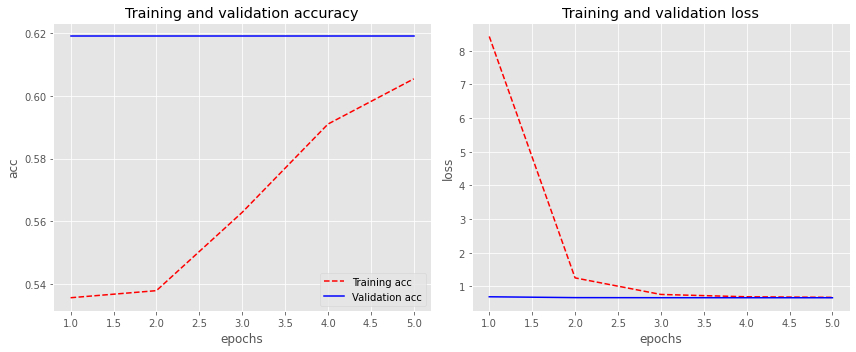

In [17]:
plot_history(history_zeros)

> Como se puede observar, se valida que la red es capaz de extraer información de las entradas y como consecuencia se puede decir que el modelo es dependiente de las entradas, es decir, es capaz de extraer información de las imagenes de entrada.

- **Sobreajuste en un lote:** Se basa en el sobreajuste de un lote de unos poquísimos ejemplos, con el objetivo de alcanzar la pérdida más baja posible. Para ello se puede aumentar las capacidades de la red, aumentando el número de capas o filtros. El objetivo es asegurar que tanto la etiqueta como la predicción coinciden al alcanzar la pérdida mínima, si no es así, es síntoma de que hay algún error en alguna parte.

In [18]:
# Se toma un lote a partir del generador, que servirá como lote a sobreajustar en el entrenamiento:
X_train, y_train = train_ds.as_numpy_iterator().next()
X_train.shape, y_train.shape

((32, 224, 224, 3), (32,))

In [19]:
def make_model_overfiting(input_shape, num_classes):

    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, strides=3, padding="same")(inputs)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(32, 3, strides=3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    initializer_weights = tf.keras.initializers.GlorotUniform()
    initializer_bias = tf.constant_initializer(0.6)
    outputs = layers.Dense(units, bias_initializer = initializer_bias, 
                           kernel_initializer = initializer_weights,
                           activation = activation)(x)
    return keras.Model(inputs, outputs)

model_overfiting = make_model_overfiting(input_shape=image_size + (3,), num_classes=num_classes)

model_overfiting.compile(pip install matplotlib
                         
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history_overfiting = model_overfiting.fit(
    X_train, y_train, validation_data=val_ds.take(1),
    validation_steps = len(val_ds.take(1)),
    epochs=240) #Se eligue un número alto de epochs para poder llegar al sobreajuste.


Epoch 1/240
1/1 [==============================] - 1s 1s/step - loss: 13.0985 - accuracy: 0.5312 - val_loss: 3.7622 - val_accuracy: 0.4062
Epoch 2/240
1/1 [==============================] - 1s 712ms/step - loss: 2.9530 - accuracy: 0.5625 - val_loss: 8.5338 - val_accuracy: 0.3750
Epoch 3/240
1/1 [==============================] - 1s 690ms/step - loss: 6.6881 - accuracy: 0.4688 - val_loss: 7.3043 - val_accuracy: 0.5625
Epoch 4/240
1/1 [==============================] - 1s 700ms/step - loss: 8.1300 - accuracy: 0.4688 - val_loss: 9.4784 - val_accuracy: 0.3125
Epoch 5/240
1/1 [==============================] - 1s 694ms/step - loss: 6.1033 - accuracy: 0.4688 - val_loss: 3.6110 - val_accuracy: 0.4688
Epoch 6/240
1/1 [==============================] - 1s 701ms/step - loss: 2.4693 - accuracy: 0.4688 - val_loss: 1.1275 - val_accuracy: 0.6875
Epoch 7/240
1/1 [==============================] - 1s 672ms/step - loss: 1.4199 - accuracy: 0.5625 - val_loss: 2.4410 - val_accuracy: 0.5938
Epoch 8/240
1/1

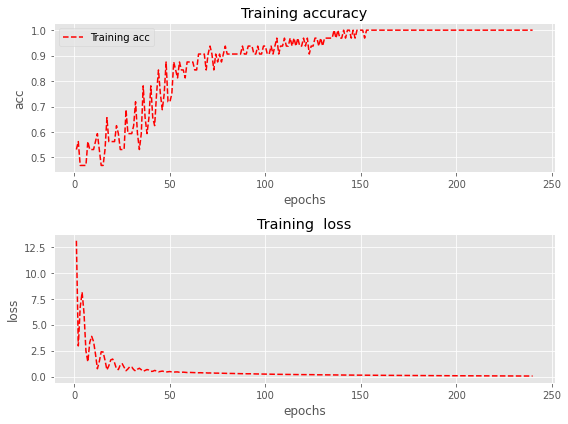

In [20]:
acc = history_overfiting.history['accuracy']
loss = history_overfiting.history['loss']

epochs = range(1, len(acc)+1, 1)
fig, axs = plt.subplots(2, 1,figsize=(8, 6))

axs[0].plot(epochs, acc, 'r--', label='Training acc')
axs[0].set_title('Training accuracy')
axs[0].set_ylabel('acc')
axs[0].set_xlabel('epochs')
axs[0].legend()
axs[1].plot(epochs, loss, 'r--' )
axs[1].set_title ('Training  loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epochs')
axs[0].legend()

fig.tight_layout()
plt.show()

- **Disminución de la pérdida en el entrenamiento:** Hasta ahora se estaba trabajando con un modelo simple y liviano, con pocos parámetros y que permite verificar el correcto funcionamiento de la red. Por ello, ahora se procede a aumentar la capacidad del modelo solo un poco, y seguidamente verificar si realmente la pérdida en el entrenamiento ha bajado como se esperaba.

In [21]:
def make_model_inc_params(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(128, 3, strides=3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    initializer_weights = tf.keras.initializers.GlorotUniform()
    initializer_bias = tf.constant_initializer(0.6)
    outputs = layers.Dense(units, bias_initializer = initializer_bias, 
                           kernel_initializer = initializer_weights,
                           activation = activation)(x)
    return keras.Model(inputs, outputs)

model_inc_params = make_model_inc_params(input_shape=image_size + (3,), num_classes=num_classes)

model_inc_params.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_inc_params = model_inc_params.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds,
    validation_steps = len(val_ds)
)

Epoch 1/5
471/471 [==============================] - 52s 109ms/step - loss: 0.6631 - accuracy: 0.6173 - val_loss: 0.6573 - val_accuracy: 0.6259
Epoch 2/5
471/471 [==============================] - 50s 107ms/step - loss: 0.6448 - accuracy: 0.6249 - val_loss: 0.6292 - val_accuracy: 0.6322
Epoch 3/5
471/471 [==============================] - 50s 106ms/step - loss: 0.6325 - accuracy: 0.6325 - val_loss: 0.6273 - val_accuracy: 0.6283
Epoch 4/5
471/471 [==============================] - 50s 106ms/step - loss: 0.6277 - accuracy: 0.6335 - val_loss: 0.6191 - val_accuracy: 0.6325
Epoch 5/5
471/471 [==============================] - 49s 105ms/step - loss: 0.6151 - accuracy: 0.6482 - val_loss: 0.6092 - val_accuracy: 0.6479


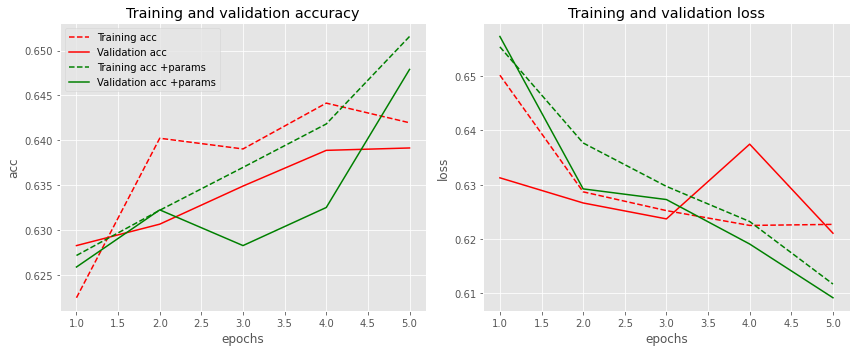

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc_aument_params = history_inc_params.history['accuracy']
val_acc_aument_params = history_inc_params.history['val_accuracy']
loss_aument_params = history_inc_params.history['loss']
val_loss_aument_params = history_inc_params.history['val_loss']

epochs = range(1, len(acc)+1, 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(epochs, acc, 'r--', label='Training acc')
axs[0].plot(epochs, val_acc,  'r', label='Validation acc')
axs[0].plot(epochs, acc_aument_params, 'b--', label='Training acc +params')
axs[0].plot(epochs, val_acc_aument_params,  'b', label='Validation acc +params')
axs[0].set_title('Training and validation accuracy')
axs[0].set_ylabel('acc')
axs[0].set_xlabel('epochs')
axs[0].legend()

axs[1].plot(epochs, loss, 'r--' )
axs[1].plot(epochs, val_loss , 'r' )
axs[1].plot(epochs, loss_aument_params, 'b--' )
axs[1].plot(epochs, val_loss_aument_params , 'b' )
axs[1].set_title ('Training and validation loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epochs')

fig.tight_layout()
plt.show()

- **Generalización o estandarización del código:** Antes de generalizar una funcionalidad relativamente general desde cero que permita adaptarse a varios casos, se debería desarrollar una función muy específica para cada caso y asegurar que funcione correctamente, para posteriormente codificar la generalización de esta.

## Sobreajuste


Antes de empezar con esta etapa, se debería tener una buena comprensión del conjunto de datos y un proceso de entrenamiento e inferencia funcionando correctamente. Con ello el modelo es fácilmente reproducible y ofrece garantías en cuanto al cálculo de las métricas adoptadas.

El enfoque para conseguir un buen modelo se basa en dos etapas:

- Obtener un modelo lo suficientemente grande como para que pueda ser adaptable en base a la pérdida en el proceso de entrenamiento.
- Posteriormente regularizar el modelo para mejorar la pérdida de validación renunciando a una parte de la pérdida del proceso de entrenamiento.

Algunos procedimientos a tener en cuenta serían:



- **Elección del modelo:** Conseguir una buena pérdida en el entrenamiento está relacionado con la elección de una arquitectura adecuada para los datos de origen. Por ello, no se debe sobredimensionar en exceso la red, sobretodo en las primeras etapas del proyecto. Una buena práctica es informarse sobre trabajos anteriores en papers que guarden similitud con el proyecto, con ello en las primeras etapas del proyecto es muy aconsejable copiar o adaptar de la mejor forma posible la arquitectura para lograr un buen rendimiento. Por ejemplo, si el proyecto se basa en la clasificación de imágenes, una buena práctica sería adaptar una arquitectura conocida como el ResNet-50 o Xception reducida en las primeras fases del proyecto. Más tarde se permitirá indagar con arquitecturas más personalizables, pero sólo si se es capaz de superar esta etapa.

In [23]:
def make_model_Xception(input_shape, num_classes, augment=True, Dropout=True,
                        sizes = [128, 256, 512, 728]):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    if augment:
      x = data_augmentation(inputs)
    else:
      x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in sizes:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    if Dropout:
      x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    initializer_weights = tf.keras.initializers.GlorotUniform()
    initializer_bias = tf.constant_initializer(0.6)
    outputs = layers.Dense(units, bias_initializer = initializer_bias, 
                           kernel_initializer = initializer_weights,
                           activation = activation)(x)

    return keras.Model(inputs, outputs)

model_Xception = make_model_Xception(input_shape=image_size + (3,), num_classes=2, 
                                     augment=False, Dropout=False)

- **Elección del Optimizador:** En las primeras etapas del proyecto, es muy aconsejable utilizar un optimizador conocido y eficiente como es el "Adam" con una tasa de aprendizaje de 3e-4. La experiencia nos dice que Adam es mucho más indulgente con los hiperparametros, aún habiendo establecido una mala tasa de aprendizaje.

In [24]:
optimizer = keras.optimizers.Adam(3e-4)

- **Adicción de complejidad:** Para cada cambio en el modelo que induzca a añadir mayor complejidad, es recomendable añadirlas de una en una, realizando las pruebas pertinentes y asegurándose de que se ha podido conseguir un aumento en el rendimiento sujeto a las expectativas.

- **Disminución de la tasa de aprendizaje:** En las primeras etapas del proyecto se recomienda deshabilitar la disminución de la tasa de aprendizaje por completo, es decir, establecer una tasa de aprendizaje constante para todo el bucle de entrenamiento. Esto es debido a que los parámetros por defectos de estas funciones están optimizado para un tipo de redes concretes, que lo más seguro es que no se adapten favorablemente al modelo del proyecto, haciendo que la tasa de aprendizaje decaiga demasiado rápido, dificultando que el modelo converja. Posteriormente en las fases finales del proyecto ya se sintonizara estos parámetros de reducción de la tasa de aprendizaje para conseguir alcanzar el mínimo valor de pérdida de entrenamiento.

In [25]:
callbacks = [
    # keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
    #                                   patience=5, min_lr=0.001)
]

In [26]:
model_Xception.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_Xception = model_Xception.fit(
    train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds,
    validation_steps = len(val_ds)
)

Epoch 1/5
471/471 [==============================] - 338s 717ms/step - loss: 0.5725 - accuracy: 0.6951 - val_loss: 0.6565 - val_accuracy: 0.6190
Epoch 2/5
471/471 [==============================] - 330s 701ms/step - loss: 0.3821 - accuracy: 0.8303 - val_loss: 0.4466 - val_accuracy: 0.7804
Epoch 3/5
471/471 [==============================] - 330s 701ms/step - loss: 0.2708 - accuracy: 0.8896 - val_loss: 0.2541 - val_accuracy: 0.8930
Epoch 4/5
471/471 [==============================] - 331s 702ms/step - loss: 0.1772 - accuracy: 0.9306 - val_loss: 0.2540 - val_accuracy: 0.8911
Epoch 5/5
471/471 [==============================] - 331s 702ms/step - loss: 0.1140 - accuracy: 0.9590 - val_loss: 0.5719 - val_accuracy: 0.7791


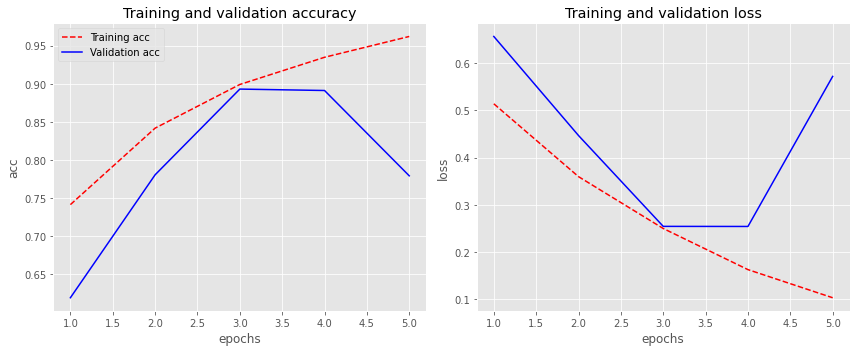

In [27]:
plot_history(history_Xception)

## Regularización.

En esta fase, se tiene un modelo adaptado al conjunto de datos de entrenamiento. Con ello, es el momento de regularizar y obtener cierta precisión del conjunto de validación renunciando a parte de la precisión en el entrenamiento. Para ello el procedimiento a seguir se basa en:

- **Obtención de más datos:** La mejor forma de regularizar el modelo en cualquier entorno práctico es agregar más datos de entrenamiento reales. El error más habitual es consumir un gran número de recursos y tiempo en tratar de exprimir el jugo a un pequeño conjunto de datos cuando en su lugar podría dedicar estos mismos recursos a la recolección de nuevos datos. Por ello, podemos concluir que la agregación de nuevos datos es la forma más eficiente de mejorar el rendimiento de una red neuronal bien configurada.

- **Aumento de los datos:** Aplicar técnicas de aumento de datos, basadas en aumentar el conjunto de datos con datos medio falsos. Por ejemplo, en imágenes se utilizan las rotaciones, las variaciones de color, los cortes parciales de imágenes, adición de ruido, entre muchas otras técnicas.


In [28]:
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(height_factor=0.1),
        layers.experimental.preprocessing.RandomCrop(height=image_size[0]-20, 
                                                     width=image_size[1]-20)
    ]
)

> Transformaciones de los datos 

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```
Con esta opción, el aumento de datos se realizará sincrónicamente con el resto de la ejecución del modelo, lo que significa que se beneficiará de la aceleración de la GPU.


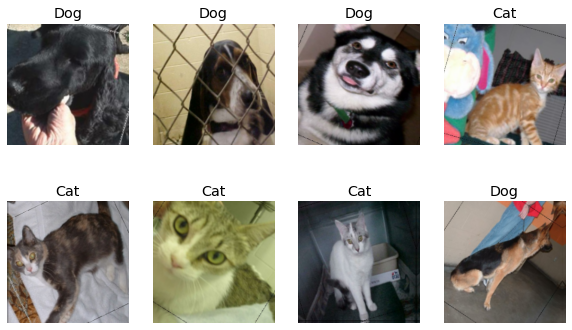

In [29]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("Cat" if int(labels[i]) == 0 else "Dog")
        plt.axis("off")

In [30]:
model_Xception_augment = make_model_Xception(input_shape=image_size + (3,), num_classes=2, 
                                             augment=True, Dropout=False)
model_Xception_augment.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_Xception_augment = model_Xception_augment.fit(
    train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds,
    validation_steps = len(val_ds)
)

Epoch 1/5
471/471 [==============================] - 306s 650ms/step - loss: 0.6630 - accuracy: 0.6333 - val_loss: 0.9102 - val_accuracy: 0.3810
Epoch 2/5
471/471 [==============================] - 299s 634ms/step - loss: 0.5456 - accuracy: 0.7252 - val_loss: 0.6306 - val_accuracy: 0.6646
Epoch 3/5
471/471 [==============================] - 299s 634ms/step - loss: 0.4259 - accuracy: 0.8038 - val_loss: 0.3697 - val_accuracy: 0.8351
Epoch 4/5
471/471 [==============================] - 298s 633ms/step - loss: 0.3273 - accuracy: 0.8587 - val_loss: 0.2724 - val_accuracy: 0.8826
Epoch 5/5
471/471 [==============================] - 299s 634ms/step - loss: 0.2736 - accuracy: 0.8820 - val_loss: 0.3086 - val_accuracy: 0.8582


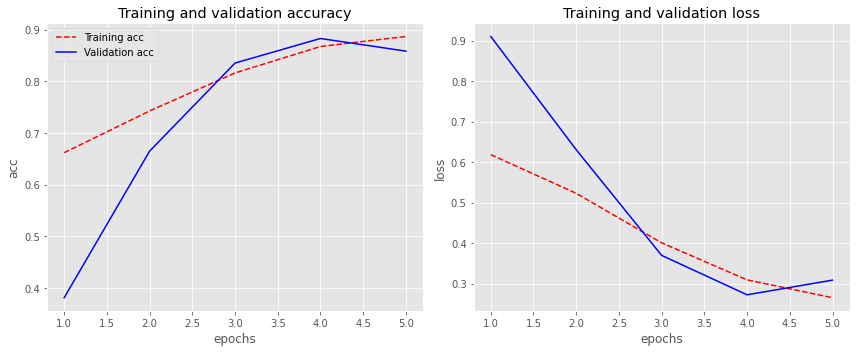

In [31]:
plot_history(history_Xception_augment)

- **Añadir pérdidas de información entre capas:** Utilizar capas de abandono (Dropouts) para ConvNets. Siempre utilizando con moderación ya que un exceso puede generar problemas con la normalización por lotes.

In [32]:
model_Xception_dropout_without_augment = make_model_Xception(input_shape=image_size + (3,), num_classes=2, 
                                             augment=False, Dropout=True)
model_Xception_dropout_without_augment.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_Xception_dropout_without_augment = model_Xception_augment.fit(
    train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds,
    validation_steps = len(val_ds)
)

Epoch 1/5
471/471 [==============================] - 296s 627ms/step - loss: 0.2277 - accuracy: 0.9030 - val_loss: 0.6406 - val_accuracy: 0.7156
Epoch 2/5
471/471 [==============================] - 296s 629ms/step - loss: 0.2078 - accuracy: 0.9151 - val_loss: 0.2071 - val_accuracy: 0.9164
Epoch 3/5
471/471 [==============================] - 296s 629ms/step - loss: 0.1850 - accuracy: 0.9247 - val_loss: 0.1692 - val_accuracy: 0.9318
Epoch 4/5
471/471 [==============================] - 296s 627ms/step - loss: 0.1730 - accuracy: 0.9302 - val_loss: 0.1871 - val_accuracy: 0.9241
Epoch 5/5
471/471 [==============================] - 295s 627ms/step - loss: 0.1615 - accuracy: 0.9334 - val_loss: 0.1497 - val_accuracy: 0.9379


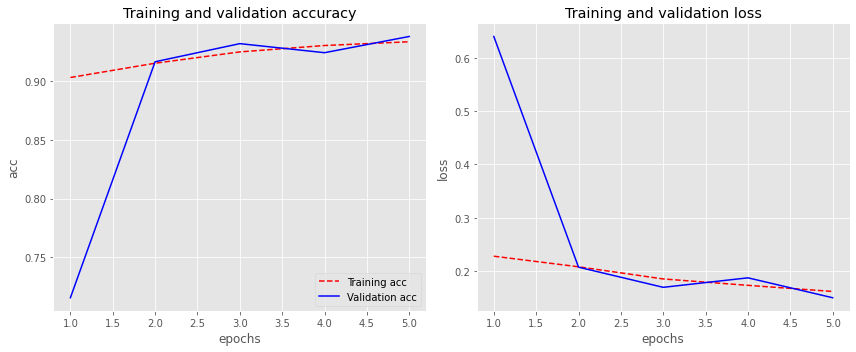

In [33]:
plot_history(history_Xception_dropout_without_augment)

- **Aumento de datos creativos:** Se están abriendo nuevas líneas de desarrollo en la expansión de los conjuntos de datos, donde se aplican técnicas de aumento de datos donde dicho dato es totalmente falso (no real). Este tipo de datos se obtienen por ejemplo entrenando redes GANs adaptadas al dominio de los datos, mediante usos de simulaciones, aleatorización de dominios, etc.

- **Pre-entrenamiento:** No dejar la oportunidad de utilizar una red pre-entrenada para intentar encontrar solución al problema.


In [34]:
pretrained_model = efn.EfficientNetB0(weights='imagenet', 
                                              input_shape=(*image_size, 3),
                                              include_top=False)
pretrained_model.trainable = False

def make_model_pretrained(input_shape, num_classes, augment=True, Dropout=True):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    if augment:
      x = data_augmentation(inputs)
    else:
      x = inputs
     # Entry block
    X = pretrained_model(x),
    x = layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dense(64, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    if Dropout:
      x = layers.Dropout(0.5)(x)

    initializer_weights = tf.keras.initializers.GlorotUniform()
    initializer_bias = tf.constant_initializer(0.6)
    outputs = layers.Dense(units, bias_initializer = initializer_bias, 
                           kernel_initializer = initializer_weights,
                           activation = activation)(x)
    return keras.Model(inputs, outputs)

model_pretrained = make_model_pretrained(input_shape=image_size + (3,), num_classes=2, 
                                             augment=True, Dropout=False)

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    model.compile(
        optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )

unfreeze_model(model_pretrained)

history_pretrained = model_pretrained.fit(
    train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds,
    validation_steps = len(val_ds)
)

Epoch 1/5
471/471 [==============================] - 50s 107ms/step - loss: 1.6228 - accuracy: 0.5647 - val_loss: 0.6702 - val_accuracy: 0.5616
Epoch 2/5
471/471 [==============================] - 49s 105ms/step - loss: 0.6800 - accuracy: 0.5885 - val_loss: 0.8605 - val_accuracy: 0.6190
Epoch 3/5
471/471 [==============================] - 49s 105ms/step - loss: 0.6907 - accuracy: 0.5736 - val_loss: 0.6569 - val_accuracy: 0.6184
Epoch 4/5
471/471 [==============================] - 49s 105ms/step - loss: 0.6878 - accuracy: 0.5796 - val_loss: 0.6502 - val_accuracy: 0.6213
Epoch 5/5
471/471 [==============================] - 49s 105ms/step - loss: 0.6805 - accuracy: 0.5885 - val_loss: 0.6534 - val_accuracy: 0.6200


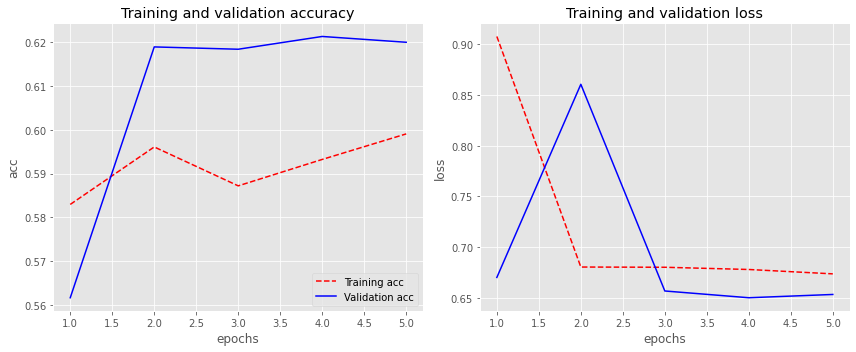

In [35]:
plot_history(history_pretrained)

- **Reducción dimensionalidad de los datos de entrada:** Se debe intentar reducir el tamaño de entrada de los datos al modelo, siempre y cuando se tenga completo conocimiento del dominio de datos. Un indicador para realizar esta reducción de dimensionalidad, es si los detalles de bajo nivel no son muy importantes y se puede prescindir de ellos reduciendo la dimensionalidad.

In [36]:
IMAGE_SIZE_REDUCE = (120, 120)

train_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=IMAGE_SIZE_REDUCE,
    batch_size=batch_size,
)
val_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=IMAGE_SIZE_REDUCE,
    batch_size=batch_size,
)

train_ds_1 = train_ds_1.prefetch(buffer_size=batch_size)
val_ds_1 = val_ds_1.prefetch(buffer_size=batch_size)

model_Xception_augment_dropout_image_reduce = make_model_Xception(input_shape=IMAGE_SIZE_REDUCE + (3,), num_classes=2, 
                                             augment=False, Dropout=True)
model_Xception_augment_dropout_image_reduce.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_Xception_augment_dropout_image_reduce = model_Xception_augment_dropout_image_reduce.fit(
    train_ds_1, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds_1,
    validation_steps = len(val_ds_1)
)

Found 18831 files belonging to 2 classes.
Using 15065 files for training.
Found 18831 files belonging to 2 classes.
Using 3766 files for validation.
Epoch 1/5
471/471 [==============================] - 101s 214ms/step - loss: 0.6293 - accuracy: 0.6651 - val_loss: 0.7964 - val_accuracy: 0.3834
Epoch 2/5
471/471 [==============================] - 96s 204ms/step - loss: 0.4061 - accuracy: 0.8171 - val_loss: 0.7718 - val_accuracy: 0.5866
Epoch 3/5
471/471 [==============================] - 96s 203ms/step - loss: 0.2921 - accuracy: 0.8739 - val_loss: 0.9705 - val_accuracy: 0.5659
Epoch 4/5
471/471 [==============================] - 95s 202ms/step - loss: 0.1989 - accuracy: 0.9181 - val_loss: 0.3594 - val_accuracy: 0.8537
Epoch 5/5
471/471 [==============================] - 95s 201ms/step - loss: 0.1228 - accuracy: 0.9506 - val_loss: 1.0463 - val_accuracy: 0.6888


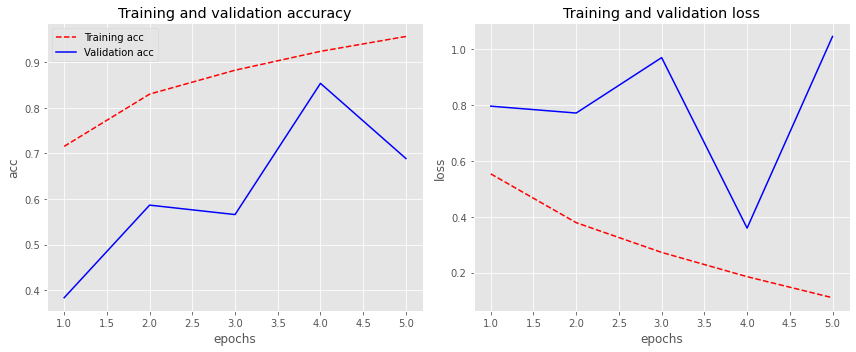

In [37]:
plot_history(history_Xception_augment_dropout_image_reduce)

- **Disminución del tamaño de lote:** La reducción del tamaño de lote (Batchsize) corresponde en cierta medida a una regularización más fuerte.

In [38]:
BATCH_SIZE_REDUCE = 16

train_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=BATCH_SIZE_REDUCE,
)
val_ds_1 = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=BATCH_SIZE_REDUCE,
)

train_ds_1 = train_ds_1.prefetch(buffer_size=batch_size)
val_ds_1 = val_ds_1.prefetch(buffer_size=batch_size)

model_Xception_augment_dropout_image_reduce_batch_size = make_model_Xception(input_shape=image_size + (3,), num_classes=2, 
                                             augment=False, Dropout=True)
model_Xception_augment_dropout_image_reduce_batch_size.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_Xception_dropout_image_reduce_batchsize = model_Xception_augment_dropout_image_reduce_batch_size.fit(
    train_ds_1, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds_1,
    validation_steps = len(val_ds_1)
)

Found 18831 files belonging to 2 classes.
Using 15065 files for training.
Found 18831 files belonging to 2 classes.
Using 3766 files for validation.
Epoch 1/5
942/942 [==============================] - 350s 371ms/step - loss: 0.6761 - accuracy: 0.6258 - val_loss: 0.5501 - val_accuracy: 0.7215
Epoch 2/5
942/942 [==============================] - 346s 367ms/step - loss: 0.5009 - accuracy: 0.7564 - val_loss: 0.4033 - val_accuracy: 0.8205
Epoch 3/5
942/942 [==============================] - 345s 366ms/step - loss: 0.3535 - accuracy: 0.8489 - val_loss: 0.3670 - val_accuracy: 0.8168
Epoch 4/5
942/942 [==============================] - 345s 367ms/step - loss: 0.2370 - accuracy: 0.9052 - val_loss: 0.2650 - val_accuracy: 0.8898
Epoch 5/5
942/942 [==============================] - 344s 365ms/step - loss: 0.1765 - accuracy: 0.9326 - val_loss: 0.2058 - val_accuracy: 0.9126


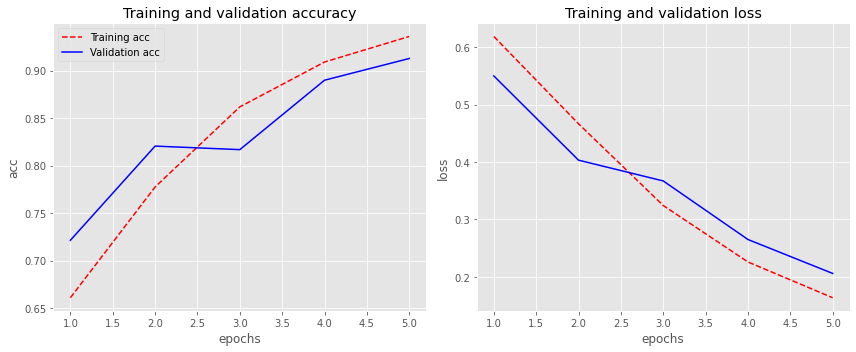

In [39]:
plot_history(history_Xception_dropout_image_reduce_batchsize)

- **Detección temprana:** Detección del proceso de entrenamiento en función de su pérdida de validación para obtener el modelo justo cuando esté en el punto de sobreajuste.

In [40]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=5, min_lr=0.001),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                  restore_best_weights=True),
]

- **Pruebas con modelos más grandes:** Puede utilizar modelos con más parámetros junto con la detección temprana, ya que muchas veces estos modelos sobredimensionados consiguen mejor rendimiento de "parada temprana".

Epoch 1/5
471/471 [==============================] - 252s 534ms/step - loss: 0.7830 - accuracy: 0.5869 - val_loss: 0.6550 - val_accuracy: 0.6190
Epoch 2/5
471/471 [==============================] - 243s 516ms/step - loss: 0.6215 - accuracy: 0.6658 - val_loss: 0.5032 - val_accuracy: 0.7499
Epoch 3/5
471/471 [==============================] - 243s 517ms/step - loss: 0.5238 - accuracy: 0.7387 - val_loss: 0.5738 - val_accuracy: 0.7384
Epoch 4/5
471/471 [==============================] - 243s 516ms/step - loss: 0.4359 - accuracy: 0.7987 - val_loss: 0.4106 - val_accuracy: 0.8163
Epoch 5/5
471/471 [==============================] - 244s 517ms/step - loss: 0.3561 - accuracy: 0.8426 - val_loss: 0.4146 - val_accuracy: 0.8083


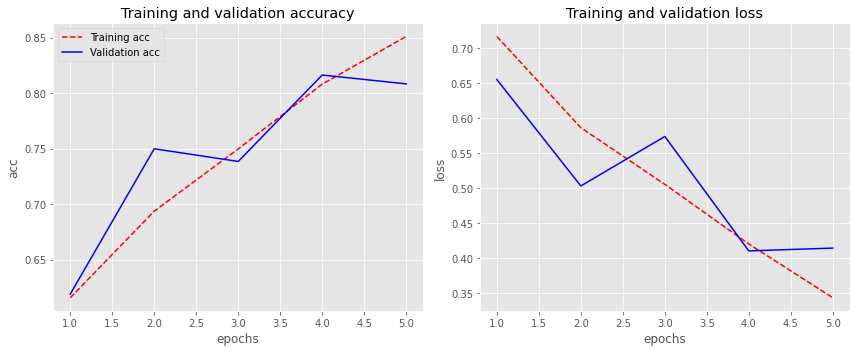

In [41]:
model_big = make_model_Xception(input_shape=image_size + (3,), num_classes=2, 
                                augment=True, Dropout=True,
                                sizes = [128, 128, 256, 256, 512, 512, 728, 728, 1024])
model_big.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history_model_big = model_big.fit(
    train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds,
    validation_steps = len(val_ds)
)          

plot_history(history_model_big)

A continuación se expone el estudio de ablación realizado a partir de todas las iteraciones realizadas:

In [45]:
resumen = [
          history, 
          history_inc_params, 
          history_model_big, 
          history_pretrained, 
          history_Xception, 
          history_Xception_augment_dropout_image_reduce, 
          history_Xception_dropout_image_reduce_batchsize,
          history_zeros
          ]

nombres = [
          "basic", 
          "inc_params", 
          "model_big", 
          "pretrained", 
          "Xception", 
          "Xception_augment_dropout_image_reduce", 
          "Xception_dropout_image_reduce_batchsize",
          "zeros"
          ]

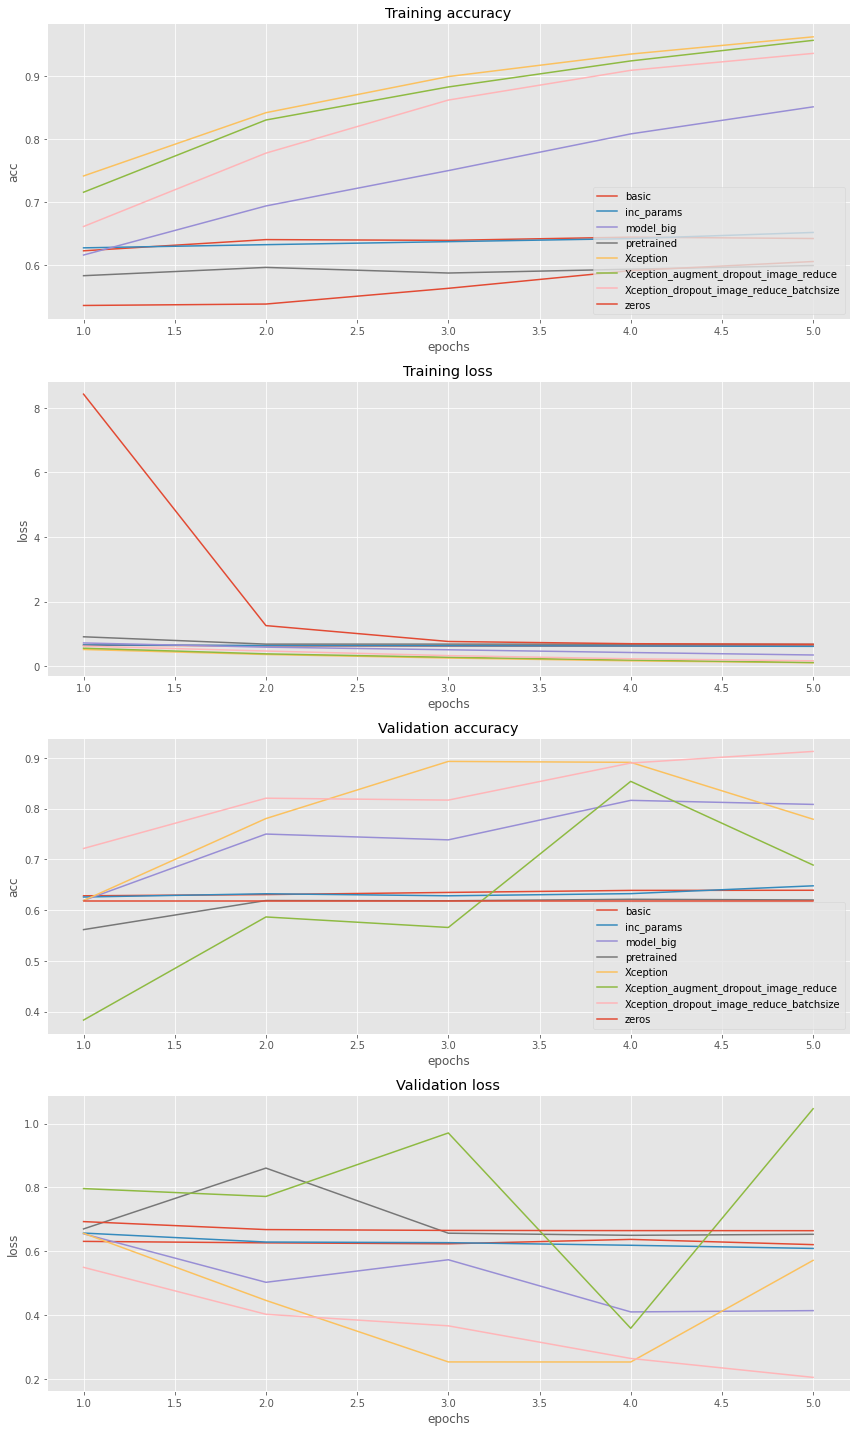

In [46]:
fig, axs = plt.subplots(4, 1,figsize=(12, 20))

for hist, name in zip(resumen, nombres):

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  epochs = range(1, len(acc)+1, 1)

  axs[0].plot(epochs, acc, label=f'{name}')
  axs[0].set_title('Training accuracy')
  axs[0].set_ylabel('acc')
  axs[0].set_xlabel('epochs')
  axs[0].legend(loc = 'lower right')

  axs[1].plot(epochs, loss)
  axs[1].set_title ('Training loss')
  axs[1].set_ylabel('loss')
  axs[1].set_xlabel('epochs')

  axs[2].plot(epochs, val_acc, label=f'{name}')
  axs[2].set_title('Validation accuracy')
  axs[2].set_ylabel('acc')
  axs[2].set_xlabel('epochs')
  axs[2].legend(loc = 'lower right')

  axs[3].plot(epochs, val_loss)
  axs[3].set_title ('Validation loss')
  axs[3].set_ylabel('loss')
  axs[3].set_xlabel('epochs')
 

fig.tight_layout()
plt.show()


Finalmente, como extra para conseguir una confianza adicional de que su red es un clasificador razonable, se pueden visualizar los pesos de la primera capa de la red para asegurarse que tenga bordes suaves con sentido. Es decir, si en los filtros de la primera capa aparece ruido, entonces algo podría estar apagado o indicar problemas en las activaciones.

## Sintonización.

Una vez se tiene una arquitectura del modelo estable y con gran adaptabilidad al conjunto de datos se puede proceder a la sintonización o búsqueda de los hiperparámetros más eficientes. Para ello se puede proceder de la siguiente manera:

- **Búsqueda aleatoria sobre cuadrícula:** Para ajustar simultáneamente múltiples hiperparámetros, es muy recomendable utilizar la búsqueda aleatoria frente a la búsqueda de cuadrícula. Esto se debe a que las redes neuronales muchas veces son más sensibles a algunos parámetros que a otros.

- **Optimización de hiperparámetros:** Existe un gran y amplio abanico de opciones para la optimización de hiperparámetros bayesianas, que ofrecen mejoras significativas y que son opciones a tener en cuenta siempre que se desee realizar este proceso de optimización de hiperparámetros.


## Mejoras finales

Una vez encontradas las mejores arquitecturas e hiperparámetros para el modelo, aún se puede usar algunas técnicas para aumentar el rendimiento del modelo:

- **Ensembling:** Se pueden adaptar como un ensembling varias arquitecturas diferentes que hayan completado todas las etapas anteriores, con ello puede garantizar el aumento de precisión de la red.

- **Detección temprana del entrenamiento**: Una detección pronta del entrenamiento cuando la pérdida por validación parece estar estabilizandose y sin tener la firme seguridad de haber entrado en overfitting, sólo puede ocasionar una pérdida de rendimiento notable en el modelo.

## Connclusiones

Una vez llegado a este punto, se puede decir que se ha adquirido un conocimiento profundo de la tecnología, el conjunto de datos y el problema. Se ha configurad una infraestructura de entrenamiento y validación adquiriendo una gran confianza en la precisión del modelo a través de las mejoras de rendimiento comentadas.